In [1]:
import ingestor, modeller, fitter
import matplotlib.pyplot as plt
import numpy as np

In [19]:
from importlib import reload
reload(ingestor)
reload(modeller)
reload(fitter)

<module 'fitter' from '/media/dwu402/Data/wrap-mad/fitter.py'>

In [3]:
plt.style.use('seaborn-notebook')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['figure.figsize'] = [15, 10]

from cycler import cycler

new_color = cycler(color=["k"])
plt.rcParams['axes.prop_cycle'] = plt.rcParams['axes.prop_cycle'].concat(new_color)

In [4]:
context = ingestor.Context("runs/minimalsp3.run")

In [5]:
solver = fitter.ParaFitter(context)

In [9]:
def replace(l, idx, val):
    return l[:idx] + [val] + l[idx+1:]

In [6]:
solver.solve(1)

In [17]:
context.update('fitting_configuration', {'regularisation_parameter': replace(context.fitting_configuration['regularisation_parameter'], 2, 0.001)})

In [20]:
solver2 = fitter.ParaFitter(context)

In [21]:
solver2.solve(1)

In [22]:
solver.solutions

{'1': [      fun: 0.03276420370235669
   hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
        jac: array([-3.51818408e-05,  2.38893716e-05,  4.22435336e-05, -2.80469996e-05,
          3.82322703e-06,  1.18781478e-06,  2.23399523e-05, -1.72661973e-05,
          2.24847357e-06, -1.96471041e-06, -5.23961166e-06])
    message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
       nfev: 107
        nit: 23
     status: 0
    success: True
          x: array([1.14446489, 1.21489938, 0.81507877, 1.23188524, 1.09027891,
         0.66886741, 0.8994874 , 0.85706644, 1.03477836, 1.22984978,
         1.089869  ]),       fun: 0.029624745507233274
   hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
        jac: array([-6.72833515e-05,  1.53266711e-04, -3.02032822e-05, -2.69634469e-05,
          1.22375522e-04,  1.38783152e-04, -2.00209899e-04, -2.32247815e-05,
         -1.48297255e-04,  5.93900760e-05,  8.62205752e-05])
    message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*

In [23]:
solver2.solutions

{'1': [      fun: 0.022867908624595177
   hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
        jac: array([-2.16624461e-04,  6.33542694e-05,  5.77668953e-06, -8.04208315e-05,
         -7.14302128e-05,  5.23290024e-04,  1.18961485e-04, -5.14555332e-04,
          9.14652462e-05, -7.04948109e-05,  2.63185858e-05])
    message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
       nfev: 131
        nit: 54
     status: 0
    success: True
          x: array([1.75481591, 2.0324571 , 1.28927499, 1.27320307, 1.57998597,
         0.52224389, 1.64145296, 0.48744415, 0.97463934, 1.57844425,
         2.32917578]),       fun: 0.02327120039463838
   hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
        jac: array([ 0.00482066, -0.00465125, -0.00068764,  0.00273014, -0.00328645,
          0.01006033,  0.00707813,  0.01331684, -0.02071951,  0.00467609,
          0.00247323])
    message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
       nfev: 39
        nit: 16
    

## Visualisations

[1.230986   1.03884235 0.86095401 1.07725231 1.10565921 0.83699953
 0.78842534 0.60824704 0.98065506 1.32894728 1.24519814]
[[ 0.00452514  0.41978279 -0.91592629]]


Text(0.5, 0, 'time, t')

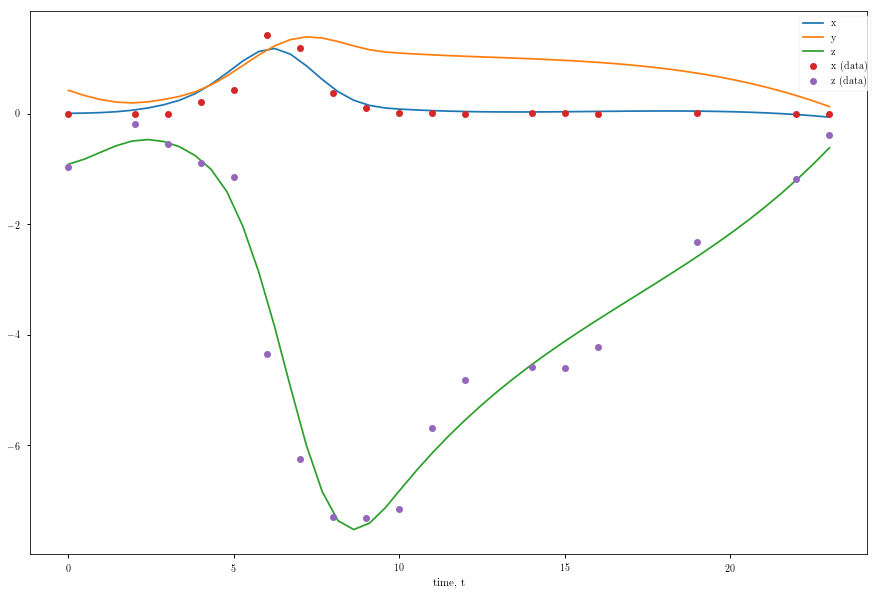

In [15]:
target_rho = 1
getx0 = fitter.ca.Function("getx", [solver.models[1].ts, *solver.models[1].cs], solver.models[1].xs)
c_end = solver.problems[1].cache.results[fitter.tokey(target_rho, solver.solutions[str(target_rho)][1].x)].x
print(solver.solutions[str(target_rho)][1].x)
xs_end = np.array([np.array(i) for i in getx0(solver.models[1].observation_times, 
                                              *fitter.argsplit(c_end, 
                                                               3)
                                             )])
print(xs_end[:,0].T)
plt.plot(solver.models[1].observation_times, np.hstack([xs_end[0], xs_end[1], xs_end[2]]),
         context.datasets[1]['t'], context.datasets[1]['x'], 'o',
         context.datasets[1]['t'], context.datasets[1]['z'], 'o')
plt.legend(list("xyz") + ["x (data)", "z (data)"], loc="best", bbox_to_anchor=(1.01, 1))
plt.xlabel("time, t")

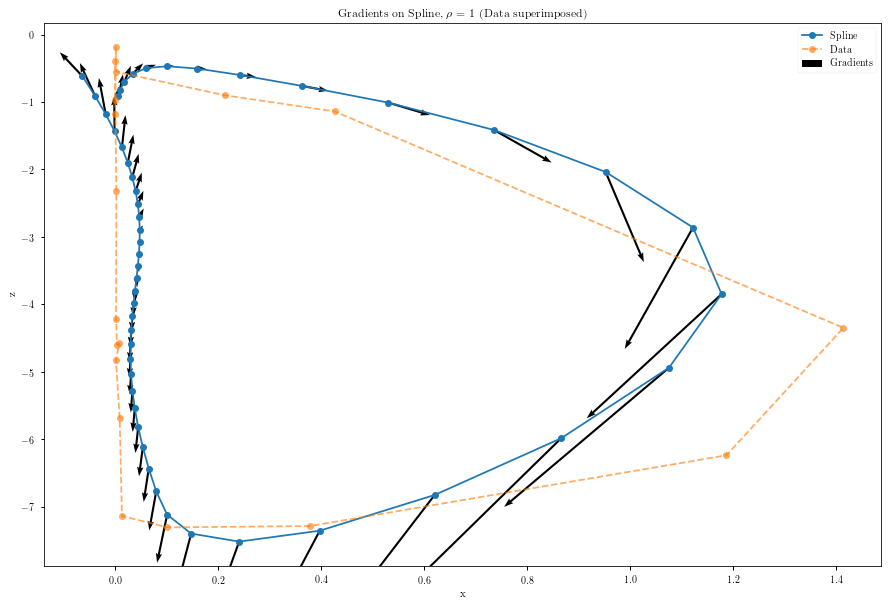

In [16]:
spline_dfield = np.array([context.model(t, xs_end[:,i], solver.solutions[str(target_rho)][0].x) 
                 for i,t in enumerate(solver.models[1].observation_times)])

spline_dfield = spline_dfield.reshape(spline_dfield.shape[:2])

plt.plot(xs_end[0], xs_end[2], 'o-')
plt.plot(context.datasets[1]['x'], context.datasets[1]['z'], 'o--', alpha=0.65)
plt.quiver(xs_end[0], xs_end[2], spline_dfield[:,0], spline_dfield[:,2], 
           scale=None, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)
plt.title(f"Gradients on Spline, $\\rho$ = {target_rho} (Data superimposed)")
plt.xlabel("x")
plt.ylabel("z")
plt.legend(["Spline", "Data", "Gradients"])